In [ ]:
import random
random.seed(27042012)
import numpy as np
np.random.seed(27042012)

import allel; print('scikit-allel', allel.__version__)

from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio import motifs

import pandascharm as pc
import dendropy as dp

import re
import itertools as it 

from multiprocessing import Pool, Manager, Process
import random

import glob 
import os.path
import pandas as pd
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')

from collections import defaultdict

In [ ]:
ld_win=500
ld_step=200
ld_thres=0.1
min_missing=0.9
outdir="filtering"
chrout="iupac/{subgenome}_chromosomes/{chromosome}{extension}"
pickleout="filtering/{filename}"
genomeout="iupac/{subgenome}/genome.fasta"
rrhsout="RRHS_fasta/{subgenome}/{replicate}.fasta"


In [ ]:
fields=["CHROM","POS","REF","ALT"]
fil_stat=defaultdict(lambda: defaultdict(int))
v_fil=dict()
g_fil=dict()
seqs=list()
meta=dict()

In [ ]:
def plot_windowed_variant_density(pos, window_size, title=None,output=None):
    
    # setup windows 
    bins = np.arange(0, pos.max(), window_size)
    
    # use window midpoints as x coordinate
    x = (bins[1:] + bins[:-1])/2
    
    # compute variant density in each window
    h, _ = np.histogram(pos, bins=bins)
    y = h / window_size
    
    # plot
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.despine(ax=ax, offset=10)
    ax.plot(x, y)
    ax.set_xlabel('Chromosome position (bp)')
    ax.set_ylabel('Variant density (bp$^{-1}$)')
    if title:
        ax.set_title(title)
    if output:
        fig.savefig(output)

In [ ]:
#for filename in glob.glob("full_vcfs/*.minocc10.maf1pc.vcf"):
#    h5_filename=filename.replace("_vcfs","_hdf5").replace(".vcf",".h5")
#    if not os.path.isfile(h5_filename):
#        allel.vcf_to_hdf5(filename, h5_filename, fields='*', overwrite=True)

In [ ]:
drop_samples = np.array(['WW-142', 'WW-466', 'WW-206', 'WW-395', 'WW-418', 'WW-129',
                'WW-193', 'WW-141', 'WW-373', 'WW-051', 'WW-199', 'WW-198',
                'WW-370', 'WW-273', 'WW-270', 'WW-130', 'WW-320', 'WW-443',
                'WW-126', 'WW-054', 'WW-275', 'WW-144', 'WW-139', 'WW-128',
                'WW-491'])
drop_samples

In [ ]:
sam=pd.read_excel("Whealbi_500samples_table.xlsx",index_col=0)
print(len(sam))
sam=sam.drop(labels=sam.index.intersection(drop_samples))
sam.Genome=sam.Genome.str.strip()
sam["subgenomeA"]=sam.Genome.str.contains("A",case=True)
sam["subgenomeB"]=sam.Genome.str.contains("B|S",case=True) # based on hypothesis that B ancestor had an S genome 
sam["subgenomeD"]=sam.Genome.str.contains("D",case=True)
sam["name"]=pd.concat([sam.Taxonomy.str.replace(" ",""),
           (sam.Taxonomy1.str.replace("^\s+","")).str.replace(regex=True,pat="(\S+)\s+.*",
                                   repl="\\1")],axis=1).apply(lambda x: "_".join(x),axis=1)
sam["taxon"]=sam["name"]
sam["name"]=sam.name +"."+sam.index
print(len(sam))
sam.head()

In [8]:
def processChromosome (filename):
    chromosome=filename.replace("/",".").split(".")[1]
    subgenome=chromosome[-1]
    
    keep_samples=list(sam.index[sam.loc[:,"subgenome"+subgenome].nonzero()].values)
    
    h5_filename="{dir}/{genome}.{chrom}.h5".format(dir=outdir,genome=subgenome,chrom=chromosome)
    if not os.path.isfile(h5_filename):
        allel.vcf_to_hdf5(filename, h5_filename, overwrite=True,alt_number=1,samples=keep_samples,
                            fields="*")
    d=h5py.File(h5_filename,mode="r")
    
    v=allel.VariantChunkedTable(d['variants'],index="POS")
    g=allel.GenotypeChunkedArray(d["calldata"]["GT"])
    
    fil_stat[chromosome]["raw"]=len(g)
    
    first_fil=v.eval("(INDEL==False) & (is_snp==True)")[:] #get rid of indels and non-snps
    vfil=v[fields][:].compress(first_fil)
    gfil=g.compress(first_fil,axis=0)
    fil_stat[chromosome]["first"]=len(gfil)

    second_fil=np.count_nonzero(~gfil.is_missing()[:],axis=1)/len(d["samples"])>min_missing
    gfil=gfil.compress(second_fil,axis=0)
    vfil=vfil.compress(second_fil,axis=0)
    ac = gfil.count_alleles()[:]
    fil_stat[chromosome]["second"]=len(gfil)

    third_fil = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1) #filter to biallelic and alt alleles with more than 1 sample
    gfil=gfil.compress(third_fil,axis=0)
    vfil=vfil.compress(third_fil,axis=0)
    ac=ac.compress(third_fil,axis=0)
    gn = gfil.to_n_alt()
    fil_stat[chromosome]["third"]=len(gfil)
    
    fourth_fil = allel.locate_unlinked(gn, size=ld_win, step=ld_step, threshold=ld_thres) # LD pruning
    gn=gn.compress(fourth_fil,axis=0)
    gfil=gfil.compress(fourth_fil,axis=0)
    vfil=vfil.compress(fourth_fil,axis=0)
    ac=ac.compress(fourth_fil,axis=0)
    fil_stat[chromosome]["fourth"]=len(gfil)

    data=dict()
    for i,s in enumerate(d["samples"]):
        seq=list()
        for j,l in enumerate(gfil[:,i]):
            if l[0]<0:
                seq.append("-")
            else:
                alleles=list(vfil[j,])[2:]
                pos=[alleles[x] for x in l]
                oseq=str(motifs.create([ Seq(x,IUPAC.ambiguous_dna) for x in pos]).degenerate_consensus)
                seq.append(oseq)
            data[s]=seq
    data=pd.DataFrame(data,index=vfil["POS"])
    r=re.compile("^[ACTG]$",re.I)
    
    fith_fil = [len(np.unique(list(filter(r.search,x))))>1 for i,x in data.iterrows()] # only segregating sites
    data=data[fith_fil] 
    matrix = pc.to_charmatrix(data, data_type='dna')
    gn=gn.compress(fith_fil,axis=0)
    gfil=gfil.compress(fith_fil,axis=0)
    vfil=vfil.compress(fith_fil,axis=0)
    ac=ac.compress(fith_fil,axis=0)
    fil_stat[chromosome]["fifth"]=len(data)
  
    v_fil[chromosome]=vfil
    g_fil[chromosome]=gfil[:]
    seqs.append(data)
    meta[chromosome]=d["samples"][:]
    
    matrix.write_to_path(dest=chrout.format(subgenome=subgenome,chromosome=chromosome,extension=".fasta"),schema="fasta")

    plot_windowed_variant_density(v["POS"], 
                                  window_size=1000000, 
                                  title='Raw variant density for '+ chromosome,
                                  output=chrout.format(subgenome=subgenome,chromosome=chromosome,extension=".raw.pdf")
                                 )
    plot_windowed_variant_density(vfil["POS"], 
                                  window_size=1000000, 
                                  title='Filtered variant density for '+ chromosome,
                                  output=chrout.format(subgenome=subgenome,chromosome=chromosome,extension=".filtered.pdf")
                                 )

full_vcfs/chr1A.minocc10.maf1pc.vcf
full_vcfs/chr2A.minocc10.maf1pc.vcf
full_vcfs/chr3A.minocc10.maf1pc.vcf
full_vcfs/chr4A.minocc10.maf1pc.vcf
full_vcfs/chr5A.minocc10.maf1pc.vcf
full_vcfs/chr6A.minocc10.maf1pc.vcf
full_vcfs/chr7A.minocc10.maf1pc.vcf
full_vcfs/chr1B.minocc10.maf1pc.vcf
full_vcfs/chr2B.minocc10.maf1pc.vcf
full_vcfs/chr3B.minocc10.maf1pc.vcf
full_vcfs/chr4B.minocc10.maf1pc.vcf


/home/pgsb/daniel.lang/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


full_vcfs/chr5B.minocc10.maf1pc.vcf
full_vcfs/chr6B.minocc10.maf1pc.vcf
full_vcfs/chr7B.minocc10.maf1pc.vcf
full_vcfs/chr1D.minocc10.maf1pc.vcf
full_vcfs/chr2D.minocc10.maf1pc.vcf
full_vcfs/chr3D.minocc10.maf1pc.vcf
full_vcfs/chr4D.minocc10.maf1pc.vcf
full_vcfs/chr5D.minocc10.maf1pc.vcf
full_vcfs/chr6D.minocc10.maf1pc.vcf
full_vcfs/chr7D.minocc10.maf1pc.vcf


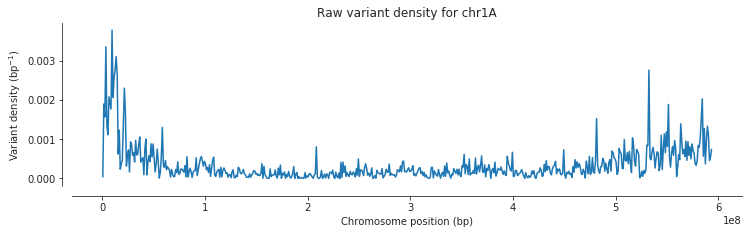

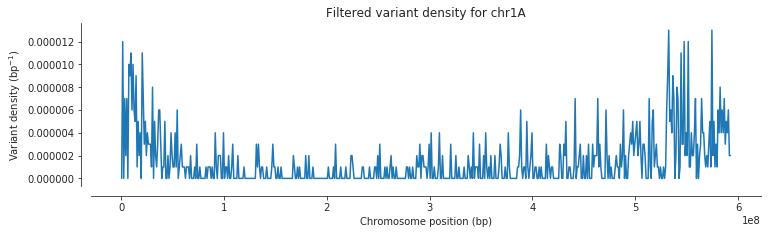

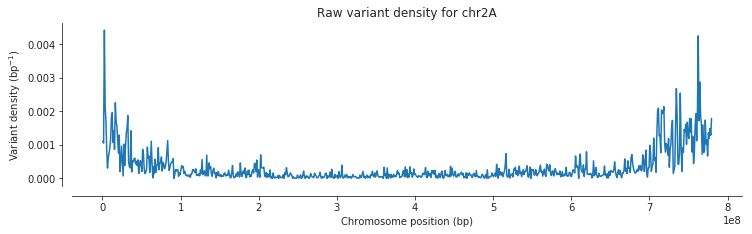

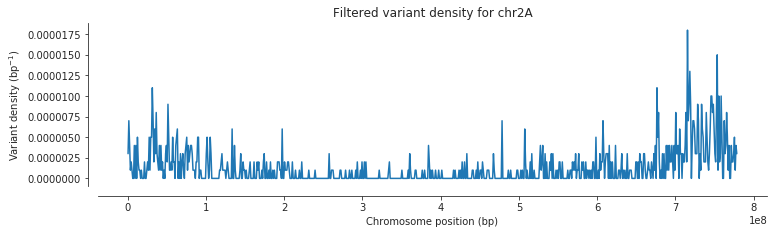

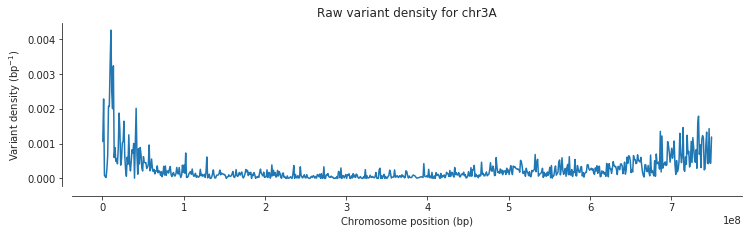

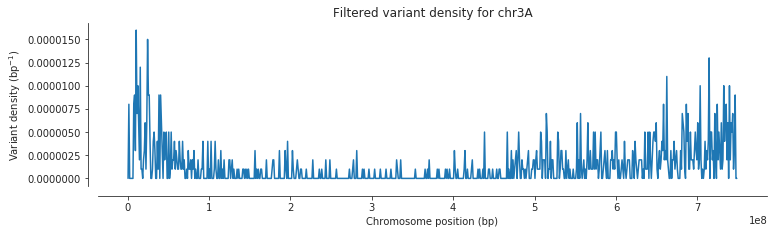

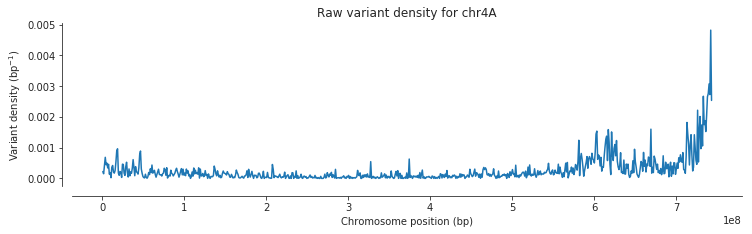

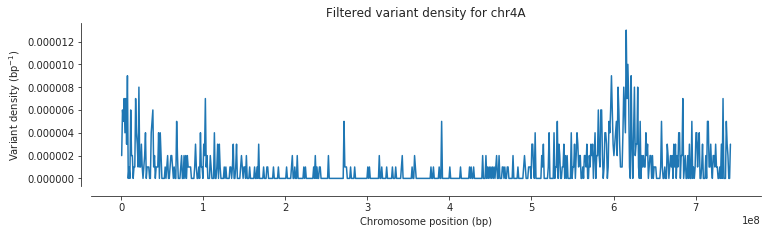

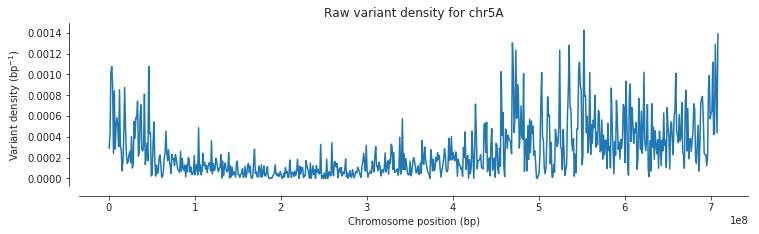

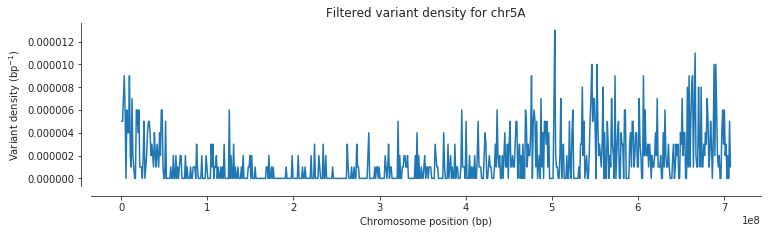

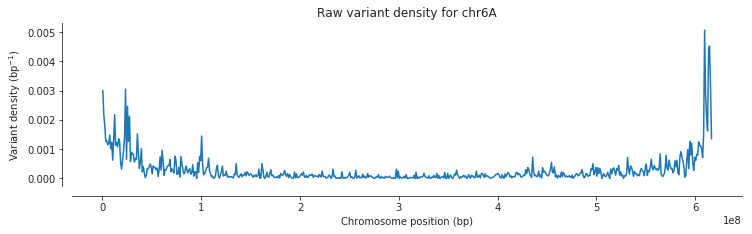

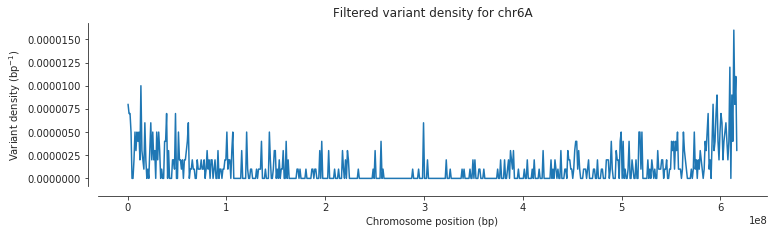

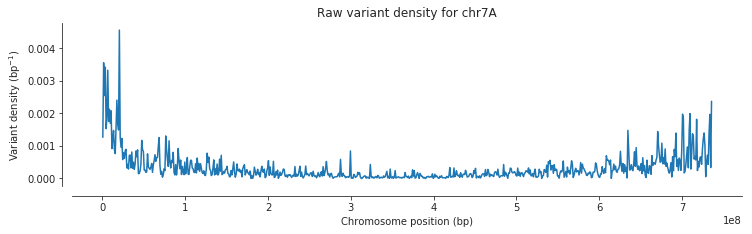

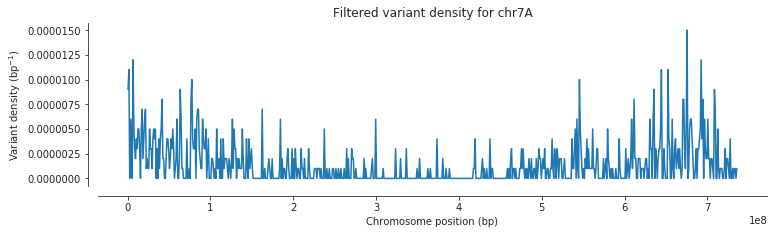

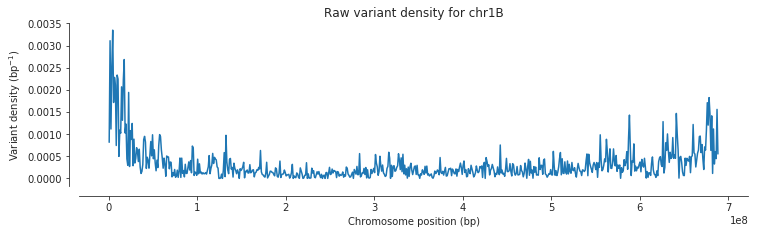

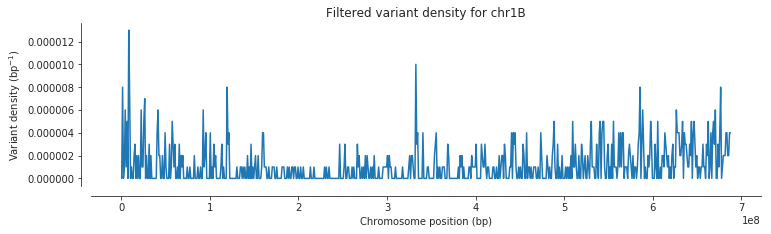

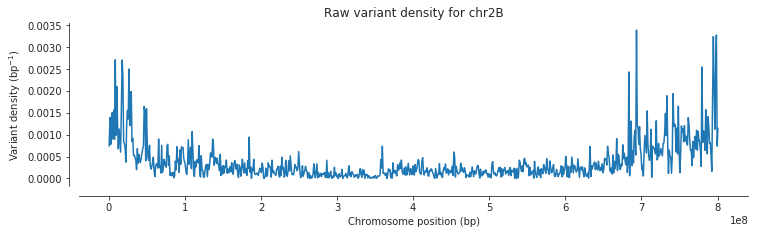

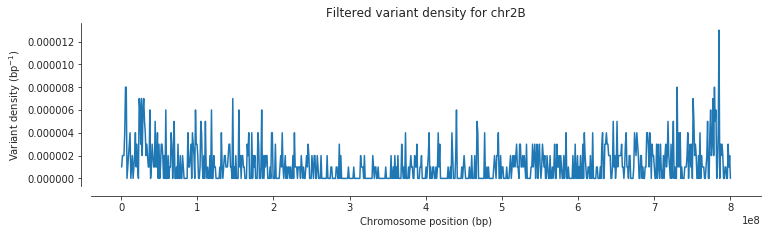

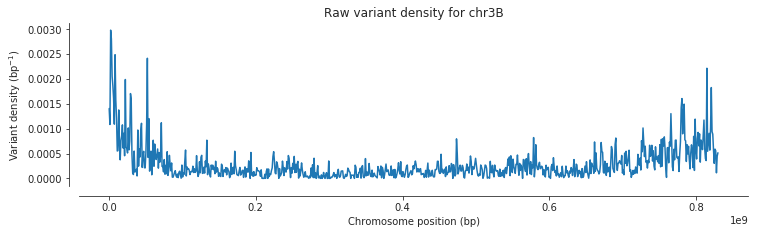

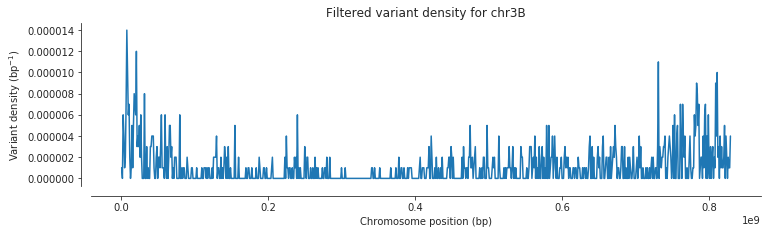

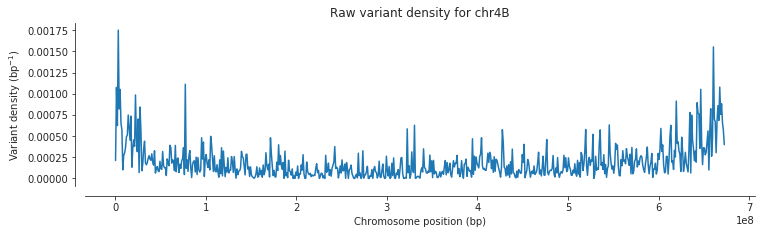

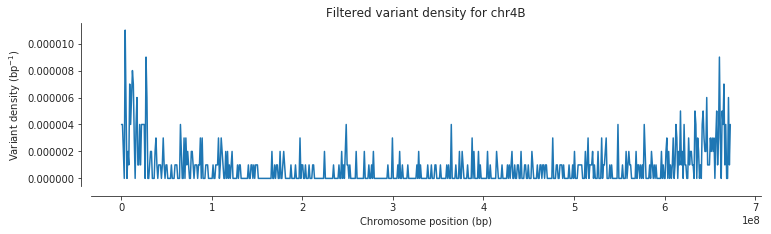

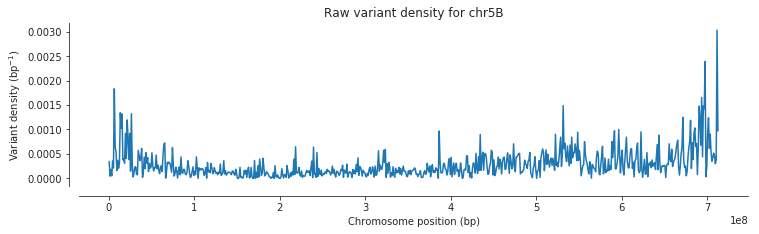

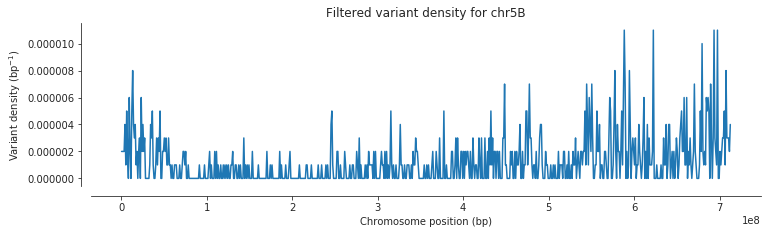

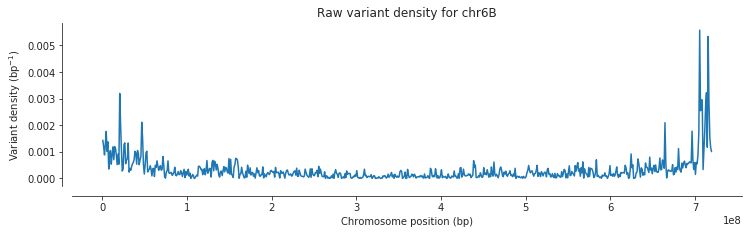

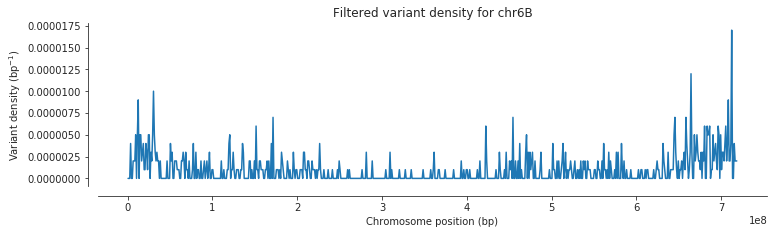

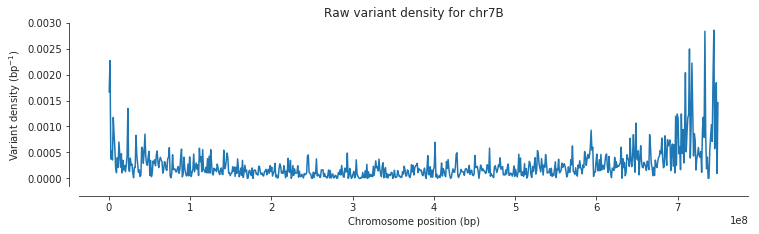

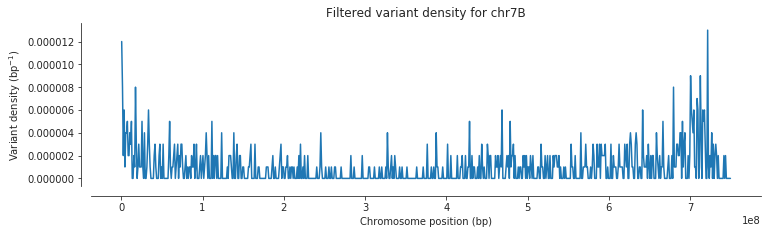

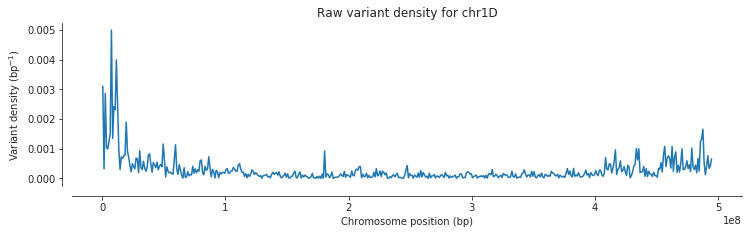

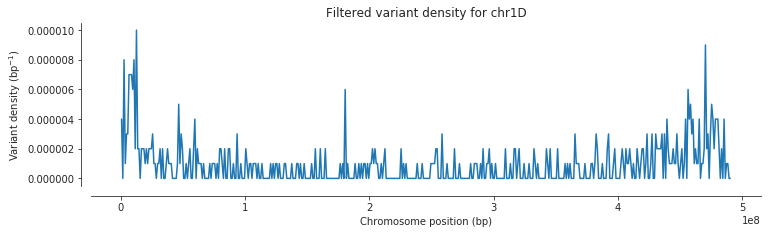

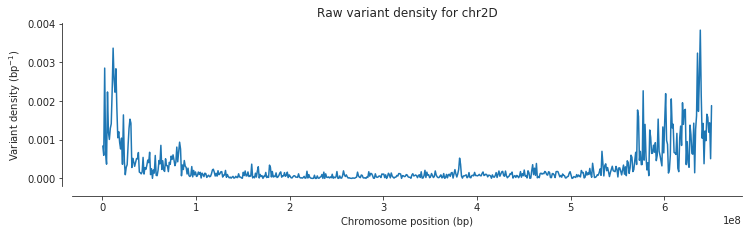

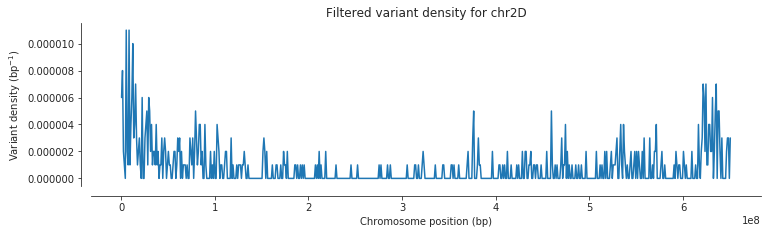

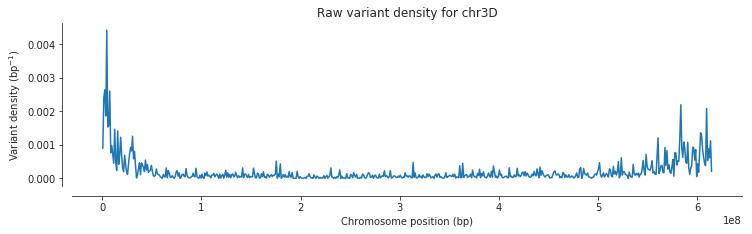

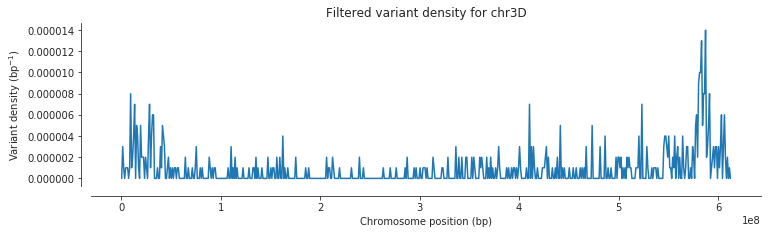

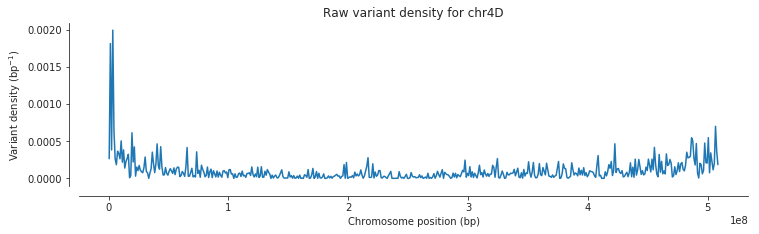

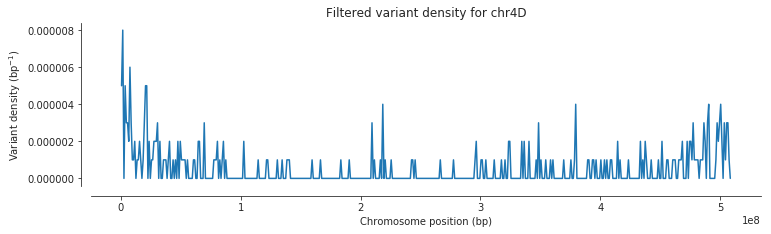

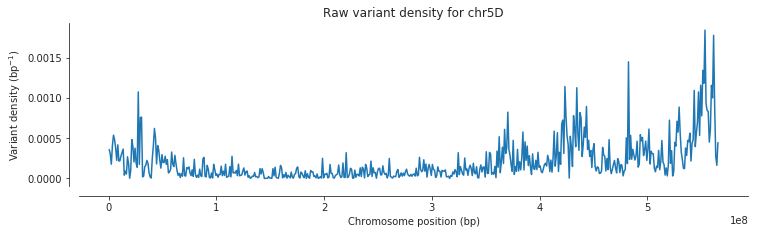

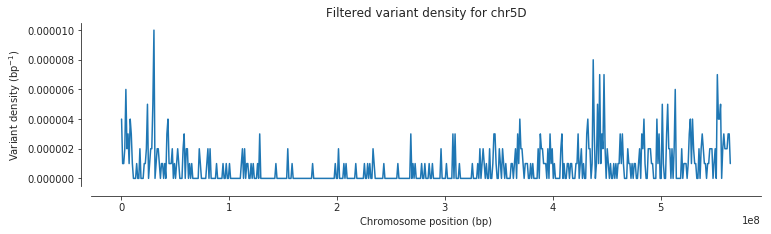

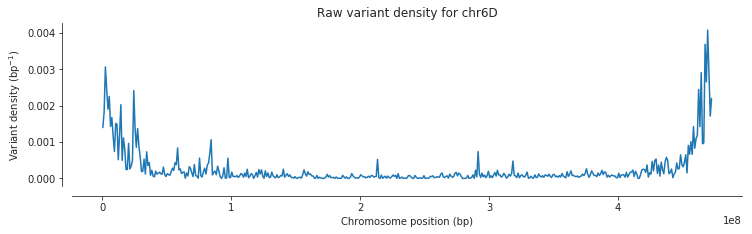

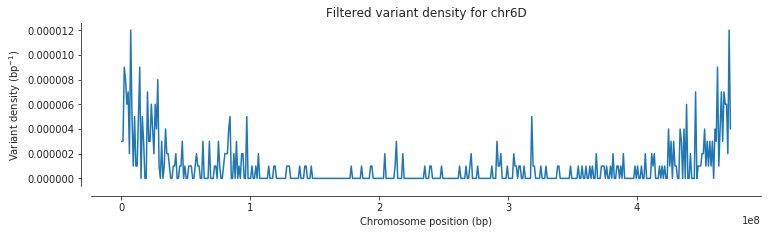

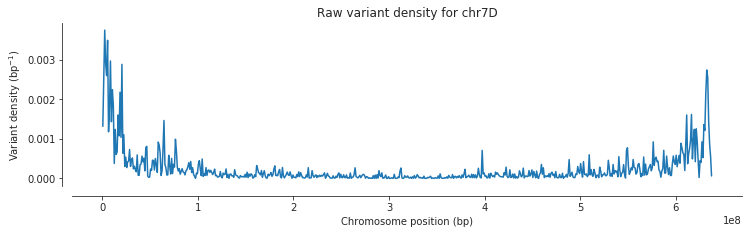

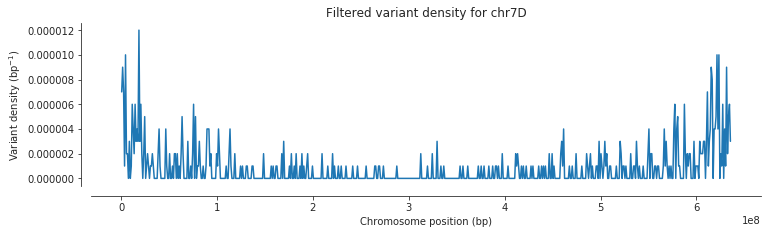

In [9]:
subgenomes=["A","B","D"]
chrs=range(1,8)
for gen in subgenomes:
    for ch in chrs:
        fn="full_vcfs/chr{chromosome}{genome}.minocc10.maf1pc.vcf".format(chromosome=ch,genome=gen)
        print(fn)
        processChromosome(fn)

In [10]:
stats=pd.DataFrame(fil_stat).transpose()[["raw","first","second","third","fourth","fifth"]]
stats["genome"]=stats.index.str.replace("chr\d+","")
stats=stats.reset_index()
stats.columns=["chromosome"]+ list(stats.columns[1:])
stats["remain"]=stats.fifth/stats.raw*100
stats

,chromosome,raw,first,second,third,fourth,fifth,genome,remain
0,chr1A,203173,190595,23402,23402,1687,886,A,0.436082
1,chr2A,256632,240776,27951,27951,2410,1038,A,0.404470
2,chr3A,196787,184121,24631,24631,1931,1023,A,0.519851
3,chr4A,195121,183327,20198,20198,1553,787,A,0.403339
4,chr5A,182645,169767,25203,25203,1935,1126,A,0.616496
5,chr6A,178894,167682,16566,16566,1358,741,A,0.414212
6,chr7A,239010,224835,23556,23556,1887,1034,A,0.432618
7,chr1B,214253,200962,18812,12873,1433,780,B,0.364056
8,chr2B,296643,279018,25700,22404,2073,985,B,0.332049
9,chr3B,234021,219401,23379,15581,1883,913,B,0.390136


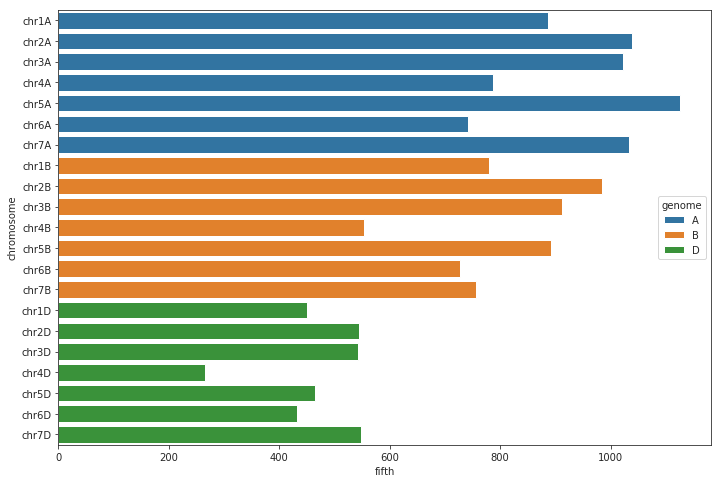

In [11]:
fig, ax = plt.subplots(figsize=(11.7, 8))
ax = sns.barplot(x="fifth", y="chromosome", hue="genome", data=stats,dodge=False)

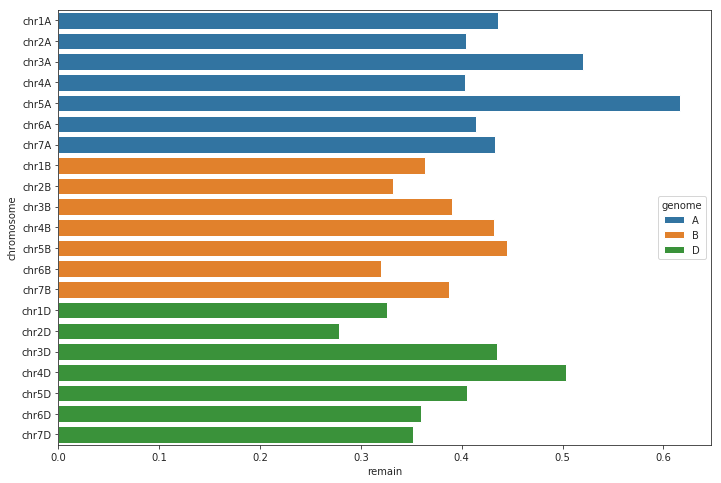

In [12]:
fig, ax = plt.subplots(figsize=(11.7, 8))
ax = sns.barplot(x="remain", y="chromosome", hue="genome", data=stats,dodge=False)

In [96]:
subgenomes=["A","B","D"]
chrs=range(1,8)
i=0
data=list()
for gen in subgenomes:
    data=list()
    data=seqs[i:i+7]
    print(len(data))
    data=pd.concat(data,axis=0)
    data.columns=sam.loc[data.columns]["name"].values
    print(data.shape)
    matrix = pc.to_charmatrix(data, data_type='dna')    
    matrix.write_to_path(dest=genomeout.format(subgenome=gen),schema="fasta")
    i+=7

7
(6635, 482)
7
(5607, 462)
7
(3248, 438)


In [53]:
stats.fifth.groupby(stats.genome).sum()

genome
A    6635
B    5607
D    3248
Name: fifth, dtype: int64

In [142]:
def randomize_alignments (genome,replicate):#,meta,g_fil,v_fil,genomeout):
    chrs=range(1,8)
    chrdata=list()
    for chrid in chrs:
        chromosome="chr{n}{g}".format(n=chrid,g=genome)
        gfil=g_fil[chromosome]
        vfil=v_fil[chromosome]
        data=dict()
        for i,s in enumerate(meta[chromosome]):
            seq=list()
            for j,l in enumerate(gfil[:,i]):
                if l[0]<0:
                    seq.append("-")
                else:
                    alleles=list(vfil[j,])[2:]
                    pos=[alleles[x] for x in l]
                    oseq=str(random.choice(list(pos)))
                    seq.append(oseq)
                data[s]=seq
        data=pd.DataFrame(data,index=[chromosome+':'+ str(x) for x in vfil["POS"]])
        r=re.compile("^[ACTG]$",re.I)
    
        fil = [len(np.unique(list(filter(r.search,x))))>1 for i,x in data.iterrows()] # only segregating sites
        chrdata.append(data[fil])
    chrdata=pd.concat(chrdata,axis=0)
    matrix = pc.to_charmatrix(chrdata, data_type='dna')
    matrix.write_to_path(dest=rrhsout.format(subgenome=genome,replicate=replicate),schema="fasta")

In [151]:
subgenomes=["A","B","D"]

#manager = Manager()
#job = [Process(target=randomize_alignments, args=(genome,i)) for genome,i in it.product(subgenomes,range(1,1001))]
pool = Pool(40)             
pool.starmap(randomize_alignments, it.product(subgenomes,range(1,1001)))

[None,
 None,
 None,
 None,
 None,
 None,
 ...]

In [208]:
subgenomes=["A","B","D"]
chrs=range(1,8)
for genome in subgenomes:
    for ch in chrs:
        chrom="chr{chromosome}{genome}".format(chromosome=ch,genome=genome)
        outname="filtered_vcfs/{chromosome}.filtered.vcf".format(chromosome=chrom)
        vcffilename="full_vcfs/chr{chromosome}{genome}.minocc10.maf1pc.vcf".format(chromosome=ch,genome=genome)
        header=list()
        with open(vcffilename, 'r') as fobj:
            header = list(takewhile(lambda s: s.startswith('#'), fobj))
        fp = open(vcffilename)
        rdr = csv.reader(filter(lambda row: row[0]!='#', fp),delimiter="\t")
        with open(outname, "wt") as csvfile:
            for x in header:
                csvfile.write(x)
            cwriter = csv.writer(csvfile, delimiter='\t', quoting=csv.QUOTE_NONE)
            i=0
            for row in rdr:
                if row[0] == chrom and int(row[1]) in v_fil[chrom]["POS"]:
                    gg=v_fil[chrom][np.where(v_fil[chrom]["POS"]==int(row[1]))]
                    if len(gg)>0 and gg[0][2] == str(row[3]) and gg[0][3] and str(row[4]):
                        cwriter.writerow(row)
                        i+=1
            fp.close()
            print("Wrote {n} filtered SNPs for {chromosome}".format(n=i,chromosome=chrom))

Wrote 886 filtered SNPs for chr1A
Wrote 1039 filtered SNPs for chr2A
Wrote 1023 filtered SNPs for chr3A
Wrote 787 filtered SNPs for chr4A
Wrote 1126 filtered SNPs for chr5A
Wrote 741 filtered SNPs for chr6A
Wrote 1034 filtered SNPs for chr7A
Wrote 780 filtered SNPs for chr1B
Wrote 985 filtered SNPs for chr2B
Wrote 914 filtered SNPs for chr3B
Wrote 553 filtered SNPs for chr4B
Wrote 893 filtered SNPs for chr5B
Wrote 727 filtered SNPs for chr6B
Wrote 756 filtered SNPs for chr7B
Wrote 451 filtered SNPs for chr1D
Wrote 545 filtered SNPs for chr2D
Wrote 542 filtered SNPs for chr3D
Wrote 265 filtered SNPs for chr4D
Wrote 465 filtered SNPs for chr5D
Wrote 432 filtered SNPs for chr6D
Wrote 548 filtered SNPs for chr7D


# PCA

In [316]:
def plot_pca_coords(coords, model, pc1, pc2, ax, sample_population,populations):
    sns.despine(ax=ax, offset=5)
    x = coords[:, pc1]
    y = coords[:, pc2]
    for pop in populations:
        flt = (sample_population == pop)
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ',label=pop, markersize=6, mec='k', mew=.5,
                color=sns.color_palette("hls", len(populations))[list(populations).index(pop)])
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    
def fig_pca(coords, model, title,sample_population,populations,output):
    # plot coords for PCs 1 vs 2, 3 vs 4
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 1)
    plot_pca_coords(coords, model, 0, 1, ax, sample_population,populations)
    ax = fig.add_subplot(1, 2, 2)
    plot_pca_coords(coords, model, 2, 3, ax, sample_population,populations)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    fig.suptitle(title, y=1.02)
    fig.tight_layout()
    fig.savefig(output)
    
def plot_PCAs (genome):
    gA=list()
    for ci in range(1,8):
        chrom="chr{i}{genome}".format(i=ci,genome=genome)
        g=g_fil[chrom]
        s=meta[chrom][:]
        gA.append(g)
    gA=allel.GenotypeArray(np.concatenate(gA,axis=0))
    gA=gA.to_n_alt()
    sam3=sam.loc[meta["chr1"+genome]]
    sam3=sam3.taxon.values
    coords1, model1 = allel.pca(gA, n_components=10, scaler='patterson')
    populations = sam.loc[meta["chr1"+genome]].taxon.unique()
    fig_pca(coords1, model1, 'Conventional PCA:' + genome,sam3,populations,"{genome}.conventionalPCA.pdf".format(genome=genome))
    coords5, model5 = allel.randomized_pca(gA, n_components=10, scaler='patterson')
    fig_pca(coords5, model5, 'Randomized PCA: '+ genome,sam3,populations,"{genome}.randomPCA.pdf".format(genome=genome))

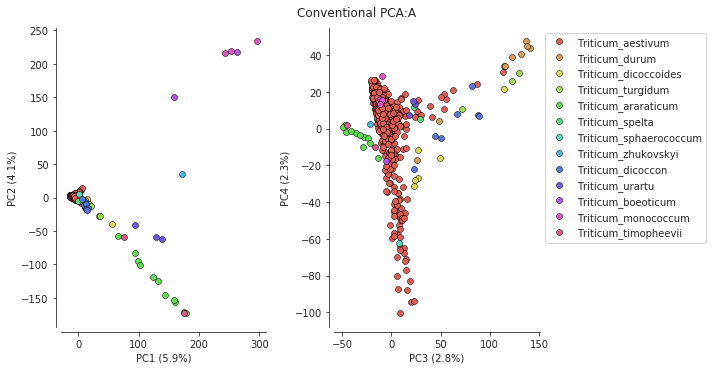

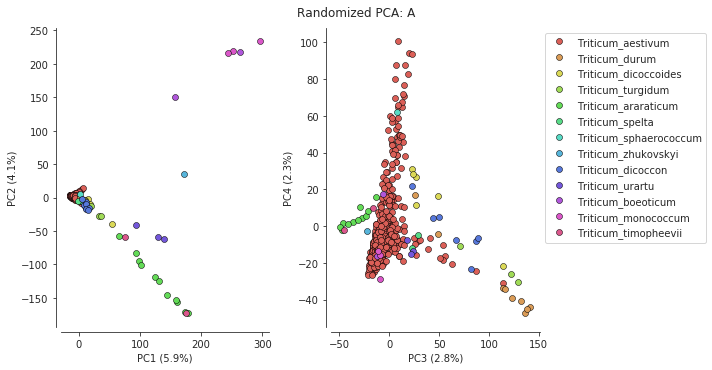

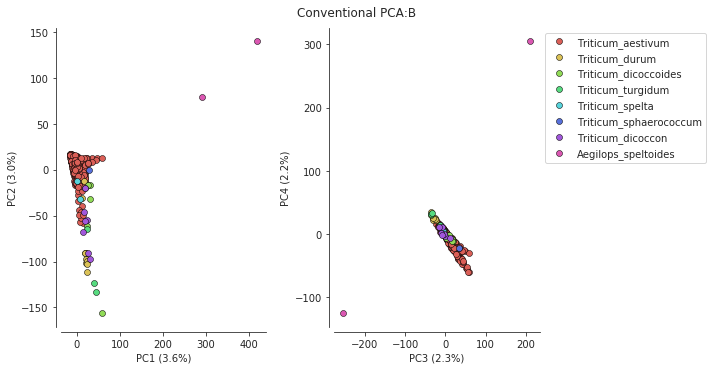

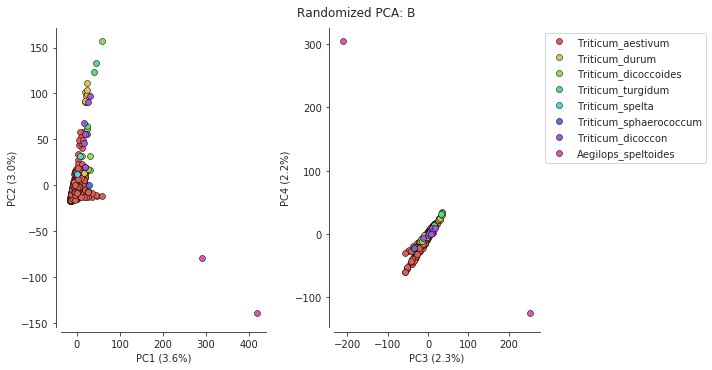

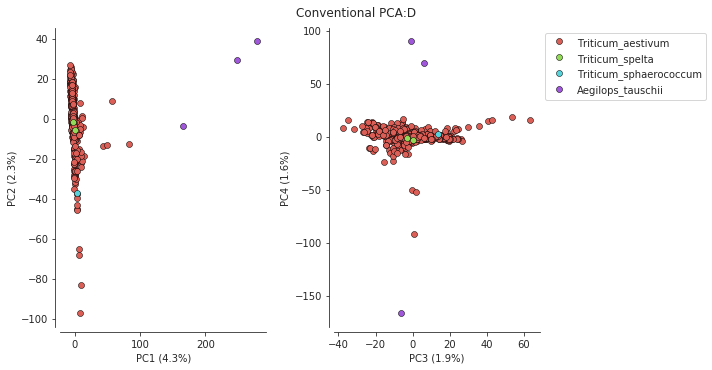

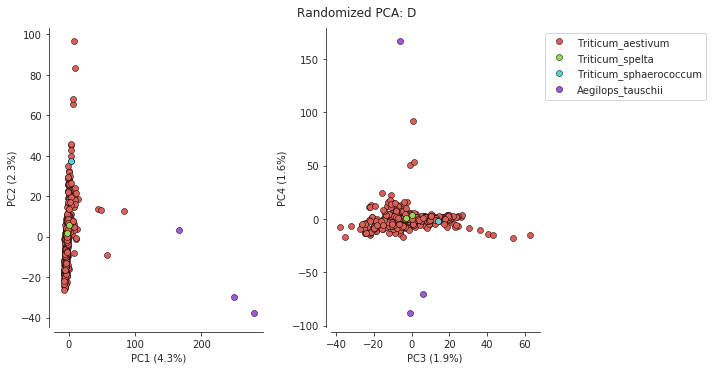

In [317]:
for genome in subgenomes:
    plot_PCAs(genome)